In [1]:
using Gen, Statistics, Memoize, Luxor
import StatsPlots, Plots


(process:21336): GLib-GIO-WARNING **: 13:07:19.493: Unexpectedly, UWP app `XBMCFoundation.Kodi_19.0.500.0_x64__4n2hpmxwrvr6p' (AUMId `XBMCFoundation.Kodi_4n2hpmxwrvr6p!Kodi') supports 120 extensions but has no verbs


## Introduction
The previous chapters have shown how to compute optimal actions for agents in MDPs and POMDPs. In many practical applications, this is the goal. For example, when controlling a robot, the goal is for the robot to act optimally given its utility function. When playing the stock market or poker, the goal is make money and one might use an approach based on the POMDP agent model from the [previous chapter](/chapters/3c-pomdp).

In other settings, however, the goal is to *learn* or *reason about* an agent based on their behavior. For example, in social science or psychology researchers often seek to learn about people's preferences (denoted $U$) and beliefs (denoted $b$). The relevant *data* (denoted $\{a_i\}$) are usually observations of human actions. In this situation, models of optimal action can be used as *generative models* of human actions. The generative model predicts the behavior *given* preferences and beliefs. That is:

$
P( \{a_i\} \vert U, b)  =: \text{Generative model of optimal action}
$

Statistical inference infers the preferences $U$ and beliefs $b$ *given* the observed actions $\{a_i\}$. That is:

$
P( U, b \vert \{a_i\})  =: \text{Invert generative model via statistical inference}
$

This approach, using generative models of sequential decision making, has been used to learn preferences and beliefs about education, work, health, and many other topics[^generative].

Agent models are also used as generative models in Machine Learning, under the label "Inverse Reinforcement Learning" (IRL). One motivation for learning human preferences and beliefs is to give humans helpful recommendations (e.g. for products they are likely to enjoy). A different goal is to build systems that mimic human expert performance. For some tasks, it is hard for humans to directly specify a utility/reward function that is both correct and that can be tractably optimized. An alternative is to *learn* the human's utility function by watching them perform the task. Once learned, the system can use standard RL techniques to optimize the function. This has been applied to building systems to park cars, to fly helicopters, to control human-like bots in videogames, and to play table tennis[^inverse].

This chapter provides an array of illustrative examples of learning about agents from their actions. We begin with a concrete example and then provide a general formalization of the inference problem. A virtue of using WebPPL is that doing inference over our existing agent models requires very little extra code.


## Learning about an agent from their actions: motivating example

Consider the MDP version of Bob's Restaurant Choice problem. Bob is choosing between restaurants, all restaurants are open (and Bob knows this), and Bob also knows the street layout. Previously, we discussed how to compute optimal behavior *given* Bob's utility function over restaurants. Now we infer Bob's utility function *given* observations of the behavior in the codebox:

┌ Info: Frames for animation "agent trajectory" are being stored in directory: 
│ 	 C:\Users\omrif\AppData\Local\Temp\jl_74TgSy
└ @ Luxor C:\Users\omrif\.julia\packages\Luxor\XHa4Y\src\animate.jl:178
┌ Info: ... 5 frames saved in directory:
│ 	 C:\Users\omrif\AppData\Local\Temp\jl_74TgSy
└ @ Luxor C:\Users\omrif\.julia\packages\Luxor\XHa4Y\src\animate.jl:200
┌ Info: GIF is: C:\Users\omrif\AppData\Local\Temp\jl_74TgSy/agent trajectory.gif
└ @ Luxor C:\Users\omrif\.julia\packages\Luxor\XHa4Y\src\animate.jl:229


Luxor.AnimatedGif("C:\\Users\\omrif\\AppData\\Local\\Temp\\jl_74TgSy/agent trajectory.gif")
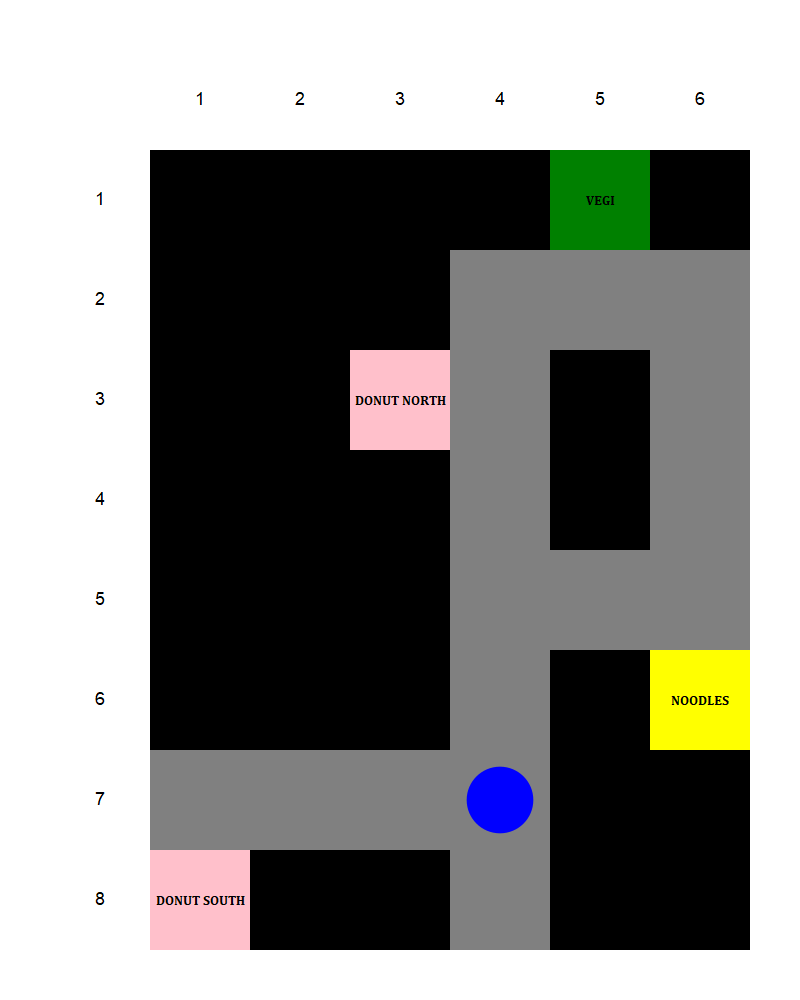

In [2]:
actions = [:up,:down,:left,:right]
grid_world = [
     "#"   "#"   "#"   "#"   "V"   "#" ; #1
     "#"   "#"   "#"  "___" "___" "___"; #2
     "#"   "#"  "DN"  "___"  "#"  "___"; #3
     "#"   "#"   "#"  "___"  "#"  "___"; #4
     "#"   "#"   "#"  "___" "___" "___"; #5
     "#"   "#"   "#"  "___"  "#"   "N" ; #6
    "___" "___" "___" "___"  "#"   "#" ; #7
    "DS"   "#"   "#"  "___"  "#"   "#" ; #8
]#    1     2     3     4     5     6
     

grid_world_utilities = Dict(
  "DS" => 1, 
  "DN" => 1, 
  "V" => 3,
  "N" => 2, 
  "___"=> -0.1
)
n_rows, n_cols = size(grid_world)
grid_size = (n_rows, n_cols)

grid_world_colors = Dict(
    "DS" => "pink", 
    "DN" => "pink",
    "V" => "green",
    "N" => "yellow", 
    "___"=> "gray",
    "#" => "black"
)

grid_world_names = Dict(
    "DS" => "DONUT SOUTH",
    "DN" => "DONUT NORTH",
    "V" => "VEGI",
    "N" => "NOODLES", 
    "___"=> "",
    "#" => ""
)

function get_state(n)
    row = (n-1) ÷ (grid_size[2] + 1)
    col = (n-1) % (grid_size[2] + 1)
    return [row, col]
end

function get_tile(state)
    return grid_world[state...]
end


target_traj = [[[7,4],:left], [[7,3],:left], [[7,2],:left], [[7,1],:down], [[8,1],:terminate]]

function get_states_list_from_trajectory(trajectory)
    return map((state_action) -> state_action[1], trajectory)
end
target_traj_states = get_states_list_from_trajectory(target_traj)

demo = Movie((n_cols + 2) * 100, (n_rows + 2) * 100, "agent trajectory", 1:length(target_traj_states))
function backdrop(scene, framenumber)
    background("white")
end

function frame(scene, framenumber)
    tiles = Tiler((n_cols + 1) * 100, (n_rows + 1) * 100, n_rows + 1,n_cols + 1, margin=0)
    agent_state = target_traj_states[framenumber]
    for (pos, n) in tiles
        state = get_state(n)
        if state[1] == 0 || state[2] == 0
            if state != [0,0]
                fontsize(18)
                fontface("")
                sethue("black")
                textcentered(string(max(state...)), pos + Point(0, 5))
            end
            continue
        end
        tile = get_tile(state)
        sethue(grid_world_colors[tile])
        box(pos, tiles.tilewidth, tiles.tileheight, :fill)
        fontsize(13)
        fontface("Cambria Bold")
        sethue("black")
        textcentered(grid_world_names[tile], pos + Point(0, 5))
        if (state == agent_state)
            sethue("blue")
            circle(pos, min(tiles.tilewidth, tiles.tileheight) / 3, :fill)
        end
    end
end

animate(demo, [
    Scene(demo, backdrop),
    Scene(demo, frame)
    ],
    framerate=5,
    creategif=true)

From Bob's actions, we infer that he probably prefers the Donut Store to the other restaurants. An alternative explanation is that Bob cares most about saving time. He might prefer Veg (the Vegetarian Cafe) but his preference is not strong enough to spend extra time getting there.

In this first example of inference, Bob's preference for saving time is held fixed and we infer (given the actions shown above) Bob's preference for the different restaurants. We model Bob using the MDP agent model from [Chapter 3.1](/chapters/3a-mdp.html). We place a uniform prior over three possible utility functions for Bob: one favoring Donut, one favoring Veg and one favoring Noodle. We compute a Bayesian posterior over these utility functions *given* Bob's observed behavior. Since the world is practically deterministic (with softmax parameter $\alpha$ set high), we just compare Bob's predicted states under each utility function to the states actually observed. To predict Bob's states for each utility function, we use the function `simulate` from [Chapter 3.1](/chapters/3a-mdp.html).

In [3]:
CONTROL_FACTOR = 50
AMOUNT_AGENT = 1000

function transition(state,action)
    if action == :down
        return [state[1]+1,state[2]]
    elseif action == :up
        return [state[1]-1, state[2]]
    elseif action == :left
        return [state[1], state[2]-1]
    elseif action == :right
        return [state[1], state[2]+1]
    end
end

function get_tile(state)
    return grid_world[state...]
end

function state_to_actions(state)
    actions = []
    if state[1] < grid_size[1] && get_tile(transition(state,:down)) != "#" 
        push!(actions,:down)
    end
    if state[1] > 1 && get_tile(transition(state,:up)) != "#"
        push!(actions,:up)
    end 
    if state[2] > 1 && get_tile(transition(state,:left)) != "#"
        push!(actions, :left)
    end 
    if state[2] < grid_size[2] && get_tile(transition(state,:right)) != "#"
        push!(actions,:right)
    end
    return actions
end

function is_terminal_state(state)
    tile = get_tile(state)
    return tile == "V" || tile == "DN" || tile == "DS" || tile == "N"
end


function make_agent(utility_table)
    function utility(state)
        return utility_table[get_tile(state)]
    end
    

    @gen function act(state, time_left)
        possible_actions = state_to_actions(state)
        action_index = @trace(uniform_discrete(1,length(possible_actions)),:action_index)
        next_action = possible_actions[action_index]
        eu = expected_utility(state, next_action, time_left)
        @trace(bernoulli(exp(CONTROL_FACTOR * eu)), :factor)
        return action_index
    end

    @memoize Dict function run_act(state, time_left)
        action_indices = []
        trace, = generate(act, (state, time_left), choicemap((:factor,1)))
        for i = 1:AMOUNT_AGENT
            trace, = Gen.mh(trace, select(:action_index))
            push!(action_indices, get_retval(trace))
        end
        return action_indices
    end

    @gen function reward(state, action, time_left)
        next_state = transition(state, action)
        action_indices = run_act(next_state, time_left)
        rand_choice = @trace(uniform_discrete(1, length(action_indices)), :rand_choice)
        possible_actions = state_to_actions(next_state)
        next_action_idx = action_indices[rand_choice]
        next_action = possible_actions[next_action_idx]
        return expected_utility(next_state, next_action, time_left)
    end

    @memoize Dict function run_reward(state, action, time_left)
        rewards = []
        trace, = generate(reward, (state, action, time_left))
        for i =1:AMOUNT_AGENT
            trace, = Gen.mh(trace, select(:rand_choice))
            push!(rewards, get_retval(trace))
        end
        return rewards
    end

    @memoize Dict function expected_utility(state, action, time_left)
        u = utility(state)
        new_time_left = time_left - 1
        if is_terminal_state(state) || new_time_left == 0
            return u
        else
            return u + mean(run_reward(state, action, new_time_left))
        end
    end
    return run_act
end

@memoize Dict function simulate_agent(utility_table, start_state, total_time, total_steps=total_time)
    trajectory = []
    run_act = make_agent(utility_table)
    next_state = start_state
    while !is_terminal_state(next_state) && total_time > 0 && total_steps > 0
        action_indices = run_act(next_state, total_time)
        possible_actions =  state_to_actions(next_state)
        rand_choice = uniform_discrete(1, length(action_indices))
        next_action_idx = action_indices[rand_choice]
        next_action = possible_actions[next_action_idx]
        push!(trajectory,[next_state,next_action])
        next_state = transition(next_state, next_action)

        total_time -= 1
        total_steps -=1
    end
    if total_time == 0 || is_terminal_state(next_state)
        push!(trajectory, [next_state,:terminate])
    end  
    return trajectory
end;

In [4]:
AMOUNT_POSTERIOR = 1000

actions = [:up,:down,:left,:right]
grid_world = [
     "#"   "#"   "#"   "#"   "V"   "#" ; #1
     "#"   "#"   "#"  "___" "___" "___"; #2
     "#"   "#"  "DN"  "___"  "#"  "___"; #3
     "#"   "#"   "#"  "___"  "#"  "___"; #4
     "#"   "#"   "#"  "___" "___" "___"; #5
     "#"   "#"   "#"  "___"  "#"   "N" ; #6
    "___" "___" "___" "___"  "#"   "#" ; #7
    "DS"   "#"   "#"  "___"  "#"   "#" ; #8
]#    1     2     3     4     5     6
n_rows, n_cols = size(grid_world)
grid_size = (n_rows, n_cols)

target_traj = [[[7,4],:left], [[7,3],:left], [[7,2],:left], [[7,1],:down], [[8,1],:terminate]]
start_state = target_traj[1][1]

options = ["donut", "veg", "noodle"]

function utility_table_prior(option_idx)
    base_table = Dict(
        "DS" => 1, 
        "DN" => 1, 
        "V" => 1,
        "N" => 1, 
        "___"=> -0.04
    )
    option = options[option_idx]
    ret_table = Dict()
    if option == "donut"
        base_table["DS"] = 2
        base_table["DN"] = 2
    elseif option == "veg"
        base_table["V"] = 2
    elseif option == "noodle"
        base_table["N"] = 2
    end
    ret_table["table"] = base_table
    ret_table["favorite"] = option
    return ret_table
end

@gen function posterior(start_state)
    option_idx = @trace(uniform_discrete(1, length(options)), :option_idx)
    utility_table_and_favorite = utility_table_prior(option_idx)
    utility_table = utility_table_and_favorite["table"]
    favorite = utility_table_and_favorite["favorite"]
    sim_traj = simulate_agent(utility_table, start_state,15)
    
    # condition
    if sim_traj == target_traj
        @trace(bernoulli(0.99), :equal_traj)
    else
        @trace(bernoulli(0.01), :equal_traj)
    end
    return favorite
end

function run_posterior(start_state)
    favorites = []
    trace, = generate(posterior, (start_state,), choicemap((:equal_traj,true)))
    for i = 1:AMOUNT_POSTERIOR
        trace, = Gen.mh(trace, select(:option_idx))
        push!(favorites, get_retval(trace))
    end
    return favorites
end;

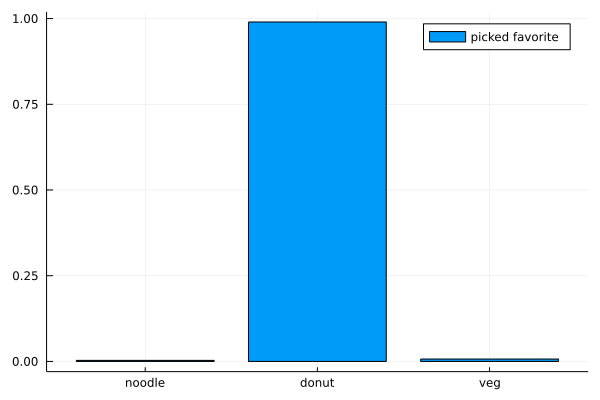

In [5]:
favorites = run_posterior(start_state)
# print(favorites)
probabilties = Dict([(option,count(favorite-> favorite==option, favorites) / AMOUNT_POSTERIOR) for option in options])
StatsPlots.bar(probabilties, label="picked favorite")

## Learning about an agent from their actions: formalization

We will now formalize the kind of inference in the previous example. We begin by considering inference over the utilities and softmax noise parameter for an MDP agent. Later on we'll generalize to POMDP agents and to other agents.

Following [Chapter 3.1](/chapters/3a-mdp.html) the MDP agent is defined by a utility function $U$ and softmax parameter $\alpha$. In order to do inference, we need to know the agent's starting state $s_0$ (which might include both their *location* and their *time horizon* $N$). The data we condition on is a sequence of state-action pairs:

$
(s_0, a_0), (s_1, a_1), \ldots, (s_n, a_n)
$

The index for the final timestep is less than or equal to the time horzion:  $n \leq N$. We abbreviate this sequence as $(s,a)_{0:n}$. The joint posterior on the agent's utilities and noise given the observed state-action sequence is:

$
P(U,\alpha | (s,a)_{0:n}) \propto P( {(s,a)}_{0:n} | U, \alpha) P(U, \alpha)
$

where the likelihood function $P( {(s,a)}_{0:n} \vert U, \alpha )$ is the MDP agent model (for simplicity we omit information about the starting state). Due to the Markov Assumption for MDPs, the probability of an agent's action in a state is independent of the agent's previous or later actions (given $U$ and $\alpha$). This allows us to rewrite the posterior as **Equation (1)**:

$
P(U,\alpha | (s,a)_{0:n}) \propto P(U, \alpha) \prod_{i=0}^n P( a_i | s_i, U, \alpha)
$


The term $P( a_i \vert s_i, U, \alpha)$ can be rewritten as the softmax choice function (which corresponds to the function `act` in our MDP agent models). This equation holds for the case where we observe a sequence of actions from timestep $0$ to $n \leq N$ (with no gaps). This tutorial focuses mostly on this case. It is trivial to extend the equation to observing multiple independently drawn such sequences (as we show below). However, if there are gaps in the sequence or if we observe only the agent's states (not the actions), then we need to marginalize over actions that were unobserved.


## Examples of learning about agents in MDPs

### Example: Inference from part of a sequence of actions

The expression for the joint posterior (above) shows that it is straightforward to do inference on a part of an agent's action sequence. For example, if we know an agent had a time horizon $N=11$, we can do inference from only the agent's first few actions.

For this example we condition on the agent making a single step from $[3,1]$ to $[2,1]$ by moving left. For an agent with low noise, this already provides very strong evidence about the agent's preferences -- not much is added by seeing the agent go all the way to Donut South.


┌ Info: Frames for animation "agent trajectory" are being stored in directory: 
│ 	 C:\Users\omrif\AppData\Local\Temp\jl_GCo1hQ
└ @ Luxor C:\Users\omrif\.julia\packages\Luxor\XHa4Y\src\animate.jl:178
┌ Info: ... 2 frames saved in directory:
│ 	 C:\Users\omrif\AppData\Local\Temp\jl_GCo1hQ
└ @ Luxor C:\Users\omrif\.julia\packages\Luxor\XHa4Y\src\animate.jl:200
┌ Info: GIF is: C:\Users\omrif\AppData\Local\Temp\jl_GCo1hQ/agent trajectory.gif
└ @ Luxor C:\Users\omrif\.julia\packages\Luxor\XHa4Y\src\animate.jl:229


Luxor.AnimatedGif("C:\\Users\\omrif\\AppData\\Local\\Temp\\jl_GCo1hQ/agent trajectory.gif")
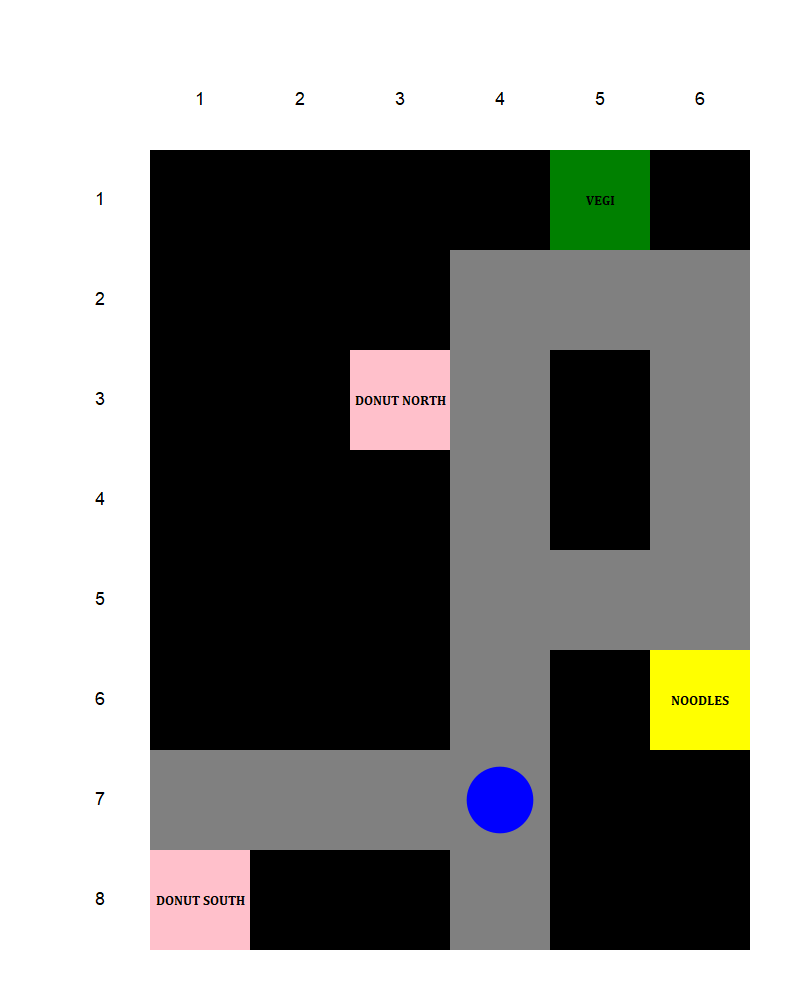

In [6]:
actions = [:up,:down,:left,:right]
grid_world = [
     "#"   "#"   "#"   "#"   "V"   "#" ; #1
     "#"   "#"   "#"  "___" "___" "___"; #2
     "#"   "#"  "DN"  "___"  "#"  "___"; #3
     "#"   "#"   "#"  "___"  "#"  "___"; #4
     "#"   "#"   "#"  "___" "___" "___"; #5
     "#"   "#"   "#"  "___"  "#"   "N" ; #6
    "___" "___" "___" "___"  "#"   "#" ; #7
    "DS"   "#"   "#"  "___"  "#"   "#" ; #8
]#    1     2     3     4     5     6
     

grid_world_utilities = Dict(
  "DS" => 1, 
  "DN" => 1, 
  "V" => 3,
  "N" => 2, 
  "___"=> -0.1
)
n_rows, n_cols = size(grid_world)
grid_size = (n_rows, n_cols)

grid_world_colors = Dict(
    "DS" => "pink", 
    "DN" => "pink",
    "V" => "green",
    "N" => "yellow", 
    "___"=> "gray",
    "#" => "black"
)

grid_world_names = Dict(
    "DS" => "DONUT SOUTH",
    "DN" => "DONUT NORTH",
    "V" => "VEGI",
    "N" => "NOODLES", 
    "___"=> "",
    "#" => ""
)

function get_state(n)
    row = (n-1) ÷ (grid_size[2] + 1)
    col = (n-1) % (grid_size[2] + 1)
    return [row, col]
end

function get_tile(state)
    return grid_world[state...]
end

observed_traj = [[7,4], [7,3]]

demo = Movie((n_cols + 2) * 100, (n_rows + 2) * 100, "agent trajectory", 1:length(observed_traj))
function backdrop(scene, framenumber)
    background("white")
end

function frame(scene, framenumber)
    tiles = Tiler((n_cols + 1) * 100, (n_rows + 1) * 100, n_rows + 1,n_cols + 1, margin=0)
    agent_state = observed_traj[framenumber]
    for (pos, n) in tiles
        state = get_state(n)
        if state[1] == 0 || state[2] == 0
            if state != [0,0]
                fontsize(18)
                fontface("")
                sethue("black")
                textcentered(string(max(state...)), pos + Point(0, 5))
            end
            continue
        end
        tile = get_tile(state)
        sethue(grid_world_colors[tile])
        box(pos, tiles.tilewidth, tiles.tileheight, :fill)
        fontsize(13)
        fontface("Cambria Bold")
        sethue("black")
        textcentered(grid_world_names[tile], pos + Point(0, 5))
        if state == agent_state
            sethue("blue")
            circle(pos, min(tiles.tilewidth, tiles.tileheight) / 3, :fill)
        end
    end
end

animate(demo, [
    Scene(demo, backdrop),
    Scene(demo, frame)
    ],
    framerate=5,
    creategif=true)

Our approach to inference is slightly different than in the example at the start of this chapter. The approach is a direct translation of the expression for the posterior in Equation (1) above. For each observed state-action pair, we compute the likelihood of the agent (with given $U$) choosing that action in the state. In contrast, the simple approach above becomes intractable for long, noisy action sequences -- as it will need to loop over all possible sequences.

In [7]:
AMOUNT_POSTERIOR = 1000

actions = [:up,:down,:left,:right]
grid_world = [
     "#"   "#"   "#"   "#"   "V"   "#" ; #1
     "#"   "#"   "#"  "___" "___" "___"; #2
     "#"   "#"  "DN"  "___"  "#"  "___"; #3
     "#"   "#"   "#"  "___"  "#"  "___"; #4
     "#"   "#"   "#"  "___" "___" "___"; #5
     "#"   "#"   "#"  "___"  "#"   "N" ; #6
    "___" "___" "___" "___"  "#"   "#" ; #7
    "DS"   "#"   "#"  "___"  "#"   "#" ; #8
]#    1     2     3     4     5     6
n_rows, n_cols = size(grid_world)
grid_size = (n_rows, n_cols)

observed_traj = [[[7,4],:left]]
start_state = observed_traj[1][1]
options = ["donut", "veg", "noodle"]

function utility_table_prior(option_idx)
    base_table = Dict(
        "DS" => 1, 
        "DN" => 1, 
        "V" => 1,
        "N" => 1, 
        "___"=> -0.04
    )
    option = options[option_idx]
    ret_table = Dict()
    if option == "donut"
        base_table["DS"] = 2
        base_table["DN"] = 2
    elseif option == "veg"
        base_table["V"] = 2
    elseif option == "noodle"
        base_table["N"] = 2
    end
    ret_table["table"] = base_table
    ret_table["favorite"] = option
    return ret_table
end

@gen function posterior(start_state)
    option_idx = @trace(uniform_discrete(1, length(options)), :option_idx)
    utility_table_and_favorite = utility_table_prior(option_idx)
    utility_table = utility_table_and_favorite["table"]
    favorite = utility_table_and_favorite["favorite"]
    for i = 1:length(observed_traj)
        state = observed_traj[i][1]
        action = observed_traj[i][2]
        single_traj = simulate_agent(utility_table, state,15,1)
        sim_action = single_traj[1][2]
        
        if sim_action == action
            @trace(bernoulli(0.99), :equal_action)
        else
            @trace(bernoulli(0.01), :equal_action)
        end
    end
    return favorite
end

function run_posterior(start_state)
    favorites = []
    trace, = generate(posterior, (start_state,), choicemap((:equal_action,true)))
    for i = 1:AMOUNT_POSTERIOR
        trace, = Gen.mh(trace, select(:option_idx))
        push!(favorites, get_retval(trace))
    end
    return favorites
end;

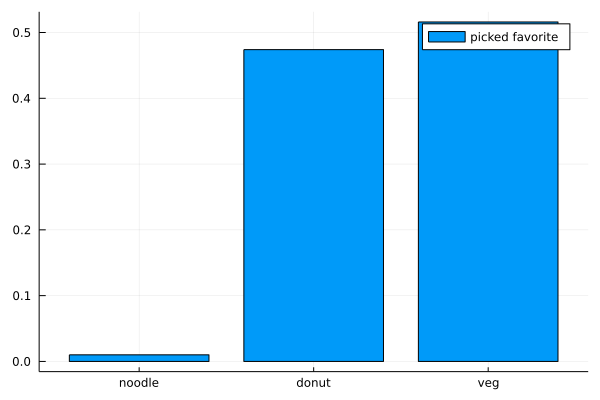

In [8]:
favorites = run_posterior(start_state)
probabilties = Dict([(option,count(favorite-> favorite==option, favorites) / AMOUNT_POSTERIOR) for option in options])
StatsPlots.bar(probabilties, label="picked favorite")

Note that utility functions where Veg or Noodle are most preferred have almost the same posterior probability. Since they had the same prior, this means that we haven't received evidence about which the agent prefers. Moreover, assuming the agent's `timeCost` is negligible, then no matter where the agent above starts out on the grid, they choose Donut North or South. So we never get any information about whether they prefer the Vegetarian Cafe or Noodle Shop!

Actually, this is not quite right. If we wait long enough, the agent's softmax noise would eventually reveal information about which was preferred. However, we still won't be able to *efficiently* learn the agent's preferences by repeatedly watching them choose from a random start point. If there is no softmax noise, then we can make the stronger claim that even in the limit of arbitrarily many repeated i.i.d. observations, the agent's preferences are not *identified* by draws from this space of scenarios.

Unidentifiability is a frequent problem when inferring an agent's beliefs or utilities from realistic datasets. First, agents with low noise reliably avoid inferior states (as in the present example) and so their actions provide little information about the relative utilities among the inferior states. Second, using richer agent models means there are more possible explanations of the same behavior. For example, agents with high softmax noise or with false beliefs might go to a restaurant even if they don't prefer it. One general approach to the problem of unidentifiability in IRL is **active learning**. Instead of passively observing the agent's actions, you select a sequence of environments that will be maximally informative about the agent's preferences. For recent work covering both the nature of unidentifiability in IRL as well as the active learning approach, see reft:amin2016towards.

### Example: Inferring The Cost of Time and Softmax Noise

The previous examples assumed that the agent's `timeCost` (the negative utility of each timestep before the agent reaches a restaurant) and the softmax $\alpha$ were known. We can modify the above example to include them in inference.

In [9]:
AMOUNT_POSTERIOR = 1000
food_values = [0,1,2]
time_cost_values = [-0.1,-0.3,-0.6]
alpha_values = [10,50,100]
# food_values = [1,2]
# time_cost_values = [-0.3,-0.6]
# alpha_values = [10,50,100]
actions = [:up,:down,:left,:right]
grid_world = [
     "#"   "#"   "#"   "#"   "V"   "#" ; #1
     "#"   "#"   "#"  "___" "___" "___"; #2
     "#"   "#"  "DN"  "___"  "#"  "___"; #3
     "#"   "#"   "#"  "___"  "#"  "___"; #4
     "#"   "#"   "#"  "___" "___" "___"; #5
     "#"   "#"   "#"  "___"  "#"   "N" ; #6
    "___" "___" "___" "___"  "#"   "#" ; #7
    "DS"   "#"   "#"  "___"  "#"   "#" ; #8
]#    1     2     3     4     5     6
n_rows, n_cols = size(grid_world)
grid_size = (n_rows, n_cols)

donut_south_traj = [[[7,4],:left], [[7,3],:left], [[7,2],:left], [[7,1],:down], [[8,1],:terminate]]
veg_direct_traj = [[[7,4],:up], [[6,4],:up], [[5,4],:up], [[4,4],:up], [[3,4],:up], [[2,4],:right],[[2,5],:up], [[1,5],:terminate]]

function utility_table_prior(donut_value_idx, veg_value_idx, noodle_value_idx, time_cost_idx)
    return Dict(
    "DS" => food_values[donut_value_idx],
    "DN" => food_values[donut_value_idx], 
    "V" => food_values[veg_value_idx],
    "N" => food_values[noodle_value_idx], 
    "___"=> time_cost_values[time_cost_idx]
    )
end

function alpha_prior(alpha_value_idx)
    return alpha_values[alpha_value_idx]
end
@gen function posterior_full_inference(observed_traj)
    donut_value_idx = @trace(uniform_discrete(1,length(food_values)), :donut_value_idx)
    veg_value_idx = @trace(uniform_discrete(1,length(food_values)), :veg_value_idx)
    noodle_value_idx = @trace(uniform_discrete(1,length(food_values)), :noodle_value_idx)
    time_cost_idx = @trace(uniform_discrete(1,length(time_cost_values)), :time_cost_idx)
    utility_table = utility_table_prior(donut_value_idx, veg_value_idx, noodle_value_idx, time_cost_idx)

    alpha_value_idx = @trace(uniform_discrete(1,length(alpha_values)), :alpha_value_idx)
    alpha = alpha_prior(alpha_value_idx)

    for i = 1:length(observed_traj)
        state = observed_traj[i][1]
        action = observed_traj[i][2]
        single_traj = simulate_agent(utility_table, state,15,1)
        sim_action = single_traj[1][2]
        if sim_action == action
            @trace(bernoulli(0.99), (:equal_action,i))
        else
            @trace(bernoulli(0.01), (:equal_action,i))
        end
    end

    is_donut_favorite = utility_table["DS"] > utility_table["V"] &&  utility_table["DS"] > utility_table["N"]
    return Dict(
        "donut_favorite" => is_donut_favorite,
        "alpha" => alpha,
        "time_cost" => utility_table["___"]
    ) 
end

function run_posterior_full_inference(observed_traj)
    results = []
    observations = Gen.choicemap()
    for i = 1:length(observed_traj)
        observations[(:equal_action,i)] = true
    end
    trace, = generate(posterior_full_inference, (observed_traj,), observations)
    for i = 1:AMOUNT_POSTERIOR
        if i%50 == 0
            println("i=$i")
        end
        trace, = Gen.mh(trace, select(:donut_value_idx))
        trace, = Gen.mh(trace, select(:veg_value_idx))
        trace, = Gen.mh(trace, select(:noodle_value_idx))
        trace, = Gen.mh(trace, select(:time_cost_idx))
        trace, = Gen.mh(trace, select(:alpha_value_idx))

        push!(results, get_retval(trace))
    end
    return results
end;

i=50
i=100
i=150
i=200
i=250
i=300
i=350
i=400
i=450
i=500
i=550
i=600
i=650
i=700
i=750
i=800
i=850
i=900
i=950
i=1000


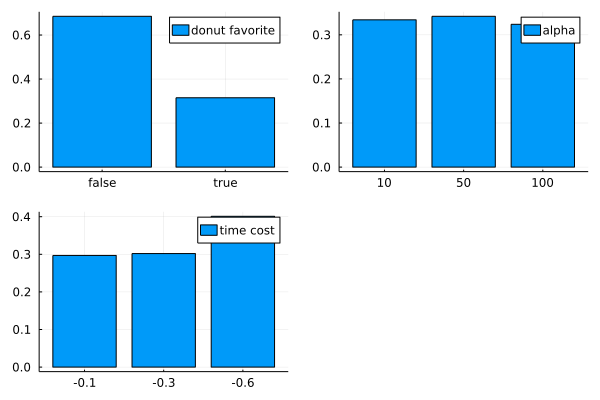

In [10]:
function display_results(results)
    donut_favorite_probs = Dict([(option,count(result-> result["donut_favorite"]==option, results) / AMOUNT_POSTERIOR) for option in [false,true]])    
    alpha_probs = Dict([(alpha,count(result-> result["alpha"]==alpha, results) / AMOUNT_POSTERIOR) for alpha in alpha_values])
    time_cost_probs = Dict([(time_cost,count(result-> result["time_cost"]==time_cost, results) / AMOUNT_POSTERIOR) for time_cost in time_cost_values])
    StatsPlots.plot(
        StatsPlots.bar(["false","true"],collect(values(donut_favorite_probs)), label="donut favorite"),
        StatsPlots.bar(map(string,alpha_values),collect(values(alpha_probs)), label="alpha"),
        StatsPlots.bar(map(string,time_cost_values), collect(values(time_cost_probs)), label="time cost")
    )
end
# prior_results = run_posterior_full_inference([])

posterior = run_posterior_full_inference(donut_south_traj[1:1])
display_results(posterior)



The posterior shows that taking a step towards Donut South can now be explained in terms of a high `timeCost`. If the agent has a low value for $\alpha$, this step to the left is fairly likely even if the agent prefers Noodle or Veg. So including softmax noise in the inference makes inferences about other parameters closer to the prior.

>**Exercise:** Suppose the agent is observed going all the way to Veg. What would the posteriors on $\alpha$ and `timeCost` look like? Check your answer by conditioning on the state-action sequence `vegDirectTrajectory`. You will need to modify other parts of the codebox above to make this work.

As we noted previously, it is simple to extend our approach to inference to conditioning on multiple sequences of actions. Consider the two sequences below:

In [11]:
actions = [:up,:down,:left,:right]
grid_world = [
     "#"   "#"   "#"   "#"   "V"   "#" ; #1
     "#"   "#"   "#"  "___" "___" "___"; #2
     "#"   "#"  "DN"  "___"  "#"  "___"; #3
     "#"   "#"   "#"  "___"  "#"  "___"; #4
     "#"   "#"   "#"  "___" "___" "___"; #5
     "#"   "#"   "#"  "___"  "#"   "N" ; #6
    "___" "___" "___" "___"  "#"   "#" ; #7
    "DS"   "#"   "#"  "___"  "#"   "#" ; #8
]#    1     2     3     4     5     6
     

grid_world_utilities = Dict(
  "DS" => 1, 
  "DN" => 1, 
  "V" => 3,
  "N" => 2, 
  "___"=> -0.1
)
n_rows, n_cols = size(grid_world)
grid_size = (n_rows, n_cols)

grid_world_colors = Dict(
    "DS" => "pink", 
    "DN" => "pink",
    "V" => "green",
    "N" => "yellow", 
    "___"=> "gray",
    "#" => "black"
)

grid_world_names = Dict(
    "DS" => "DONUT SOUTH",
    "DN" => "DONUT NORTH",
    "V" => "VEGI",
    "N" => "NOODLES", 
    "___"=> "",
    "#" => ""
)

function get_state(n)
    row = (n-1) ÷ (grid_size[2] + 1)
    col = (n-1) % (grid_size[2] + 1)
    return [row, col]
end

function get_tile(state)
    return grid_world[state...]
end

donut_south_traj = [[[7,4],:left], [[7,3],:left], [[7,2],:left], [[7,1],:down], [[8,1],:terminate]]
naive_traj = [[[7,4],:up], [[6,4],:up], [[5,4],:up], [[4,4],:up], [[3,4],:left], [[3,3],:terminate]]

function get_states_list_from_trajectory(trajectory)
    return map((state_action) -> state_action[1], trajectory)
end

function animate_trajectory(trajectory)
    demo = Movie((n_cols + 2) * 100, (n_rows + 2) * 100, "agent trajectory", 1:length(trajectory))
    function backdrop(scene, framenumber)
        background("white")
    end

    function frame(scene, framenumber)
        tiles = Tiler((n_cols + 1) * 100, (n_rows + 1) * 100, n_rows + 1,n_cols + 1, margin=0)
        agent_state = trajectory[framenumber]
        for (pos, n) in tiles
            state = get_state(n)
            if state[1] == 0 || state[2] == 0
                if state != [0,0]
                    fontsize(18)
                    fontface("")
                    sethue("black")
                    textcentered(string(max(state...)), pos + Point(0, 5))
                end
                continue
            end
            tile = get_tile(state)
            sethue(grid_world_colors[tile])
            box(pos, tiles.tilewidth, tiles.tileheight, :fill)
            fontsize(13)
            fontface("Cambria Bold")
            sethue("black")
            textcentered(grid_world_names[tile], pos + Point(0, 5))
            if state == agent_state
                sethue("blue")
                circle(pos, min(tiles.tilewidth, tiles.tileheight) / 3, :fill)
            end
        end
    end

    animate(demo, [
        Scene(demo, backdrop),
        Scene(demo, frame),
        ],
        framerate=5,
        creategif=true)

end;


┌ Info: Frames for animation "agent trajectory" are being stored in directory: 
│ 	 C:\Users\omrif\AppData\Local\Temp\jl_u5leiu
└ @ Luxor C:\Users\omrif\.julia\packages\Luxor\XHa4Y\src\animate.jl:178
┌ Info: ... 5 frames saved in directory:
│ 	 C:\Users\omrif\AppData\Local\Temp\jl_u5leiu
└ @ Luxor C:\Users\omrif\.julia\packages\Luxor\XHa4Y\src\animate.jl:200
┌ Info: GIF is: C:\Users\omrif\AppData\Local\Temp\jl_u5leiu/agent trajectory.gif
└ @ Luxor C:\Users\omrif\.julia\packages\Luxor\XHa4Y\src\animate.jl:229


Luxor.AnimatedGif("C:\\Users\\omrif\\AppData\\Local\\Temp\\jl_u5leiu/agent trajectory.gif")
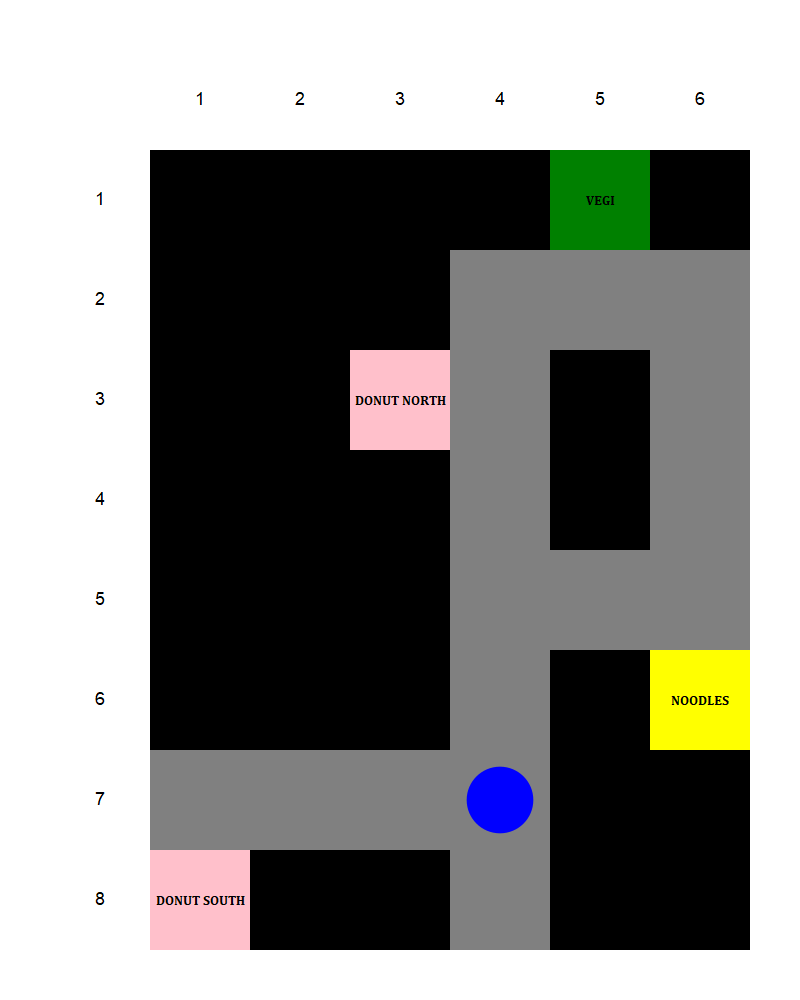

In [12]:
animate_trajectory(get_states_list_from_trajectory(donut_south_traj))

┌ Info: Frames for animation "agent trajectory" are being stored in directory: 
│ 	 C:\Users\omrif\AppData\Local\Temp\jl_FMpC7s
└ @ Luxor C:\Users\omrif\.julia\packages\Luxor\XHa4Y\src\animate.jl:178
┌ Info: ... 6 frames saved in directory:
│ 	 C:\Users\omrif\AppData\Local\Temp\jl_FMpC7s
└ @ Luxor C:\Users\omrif\.julia\packages\Luxor\XHa4Y\src\animate.jl:200
┌ Info: GIF is: C:\Users\omrif\AppData\Local\Temp\jl_FMpC7s/agent trajectory.gif
└ @ Luxor C:\Users\omrif\.julia\packages\Luxor\XHa4Y\src\animate.jl:229


Luxor.AnimatedGif("C:\\Users\\omrif\\AppData\\Local\\Temp\\jl_FMpC7s/agent trajectory.gif")
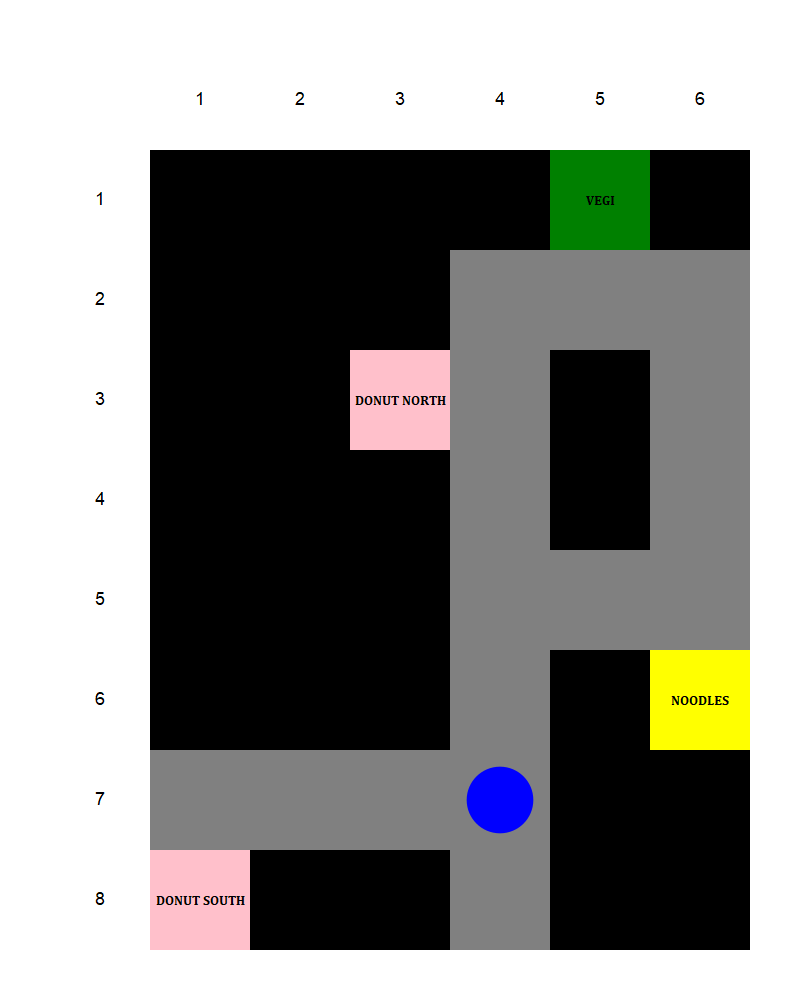

In [13]:
animate_trajectory(get_states_list_from_trajectory(naive_traj))

To perform inference, we just condition on both sequences. (We use concatenation but we could have taken the union of all state-action pairs).

In [14]:
function display_results(results)
    donut_favorite_probs = Dict([(option,count(result-> result["donut_favorite"]==option, results) / AMOUNT_POSTERIOR) for option in [false,true]])    
    alpha_probs = Dict([(alpha,count(result-> result["alpha"]==alpha, results) / AMOUNT_POSTERIOR) for alpha in alpha_values])
    time_cost_probs = Dict([(time_cost,count(result-> result["time_cost"]==time_cost, results) / AMOUNT_POSTERIOR) for time_cost in time_cost_values])
    StatsPlots.plot(
        StatsPlots.bar(["false","true"],collect(values(donut_favorite_probs)), label="donut favorite"),
        StatsPlots.bar(map(string,alpha_values),collect(values(alpha_probs)), label="alpha"),
        StatsPlots.bar(map(string,time_cost_values), collect(values(time_cost_probs)), label="time cost")
    )
end;

i=50
i=100
i=150
i=200
i=250
i=300
i=350
i=400
i=450
i=500
i=550
i=600
i=650
i=700
i=750
i=800
i=850
i=900
i=950
i=1000


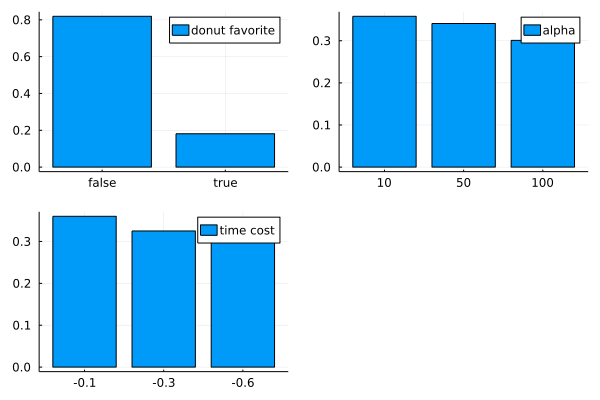

In [15]:
prior = run_posterior_full_inference([])
display_results(prior)

In [16]:
prior = run_posterior_full_inference(vcat(naive_traj,donut_south_traj))
display_results(prior)

LoadError: UndefVarError: donut_souוואth_traj not defined

## Learning about agents in POMDPs

### Formalization

We can extend our approach to inference to deal with agents that solve POMDPs. One approach to inference is simply to generate full state-action sequences and compare them to the observed data. As we mentioned above, this approach becomes intractable in cases where noise (in transitions and actions) is high and sequences are long.

Instead, we extend the approach in Equation (1) above. The first thing to notice is that Equation (1) has to be amended for POMDPs. In an MDP, actions are conditionally independent given the agent's parameters $U$ and $\alpha$ and the state. For any pair of actions $a_{i}$ and $a_j$ and state $s_i$:

$
P(a_i \vert a_j, s_i, U,\alpha) = P(a_i \vert s_i, U,\alpha)
$

In a POMDP, actions are only rendered conditionally independent if we also condition on the agent's *belief*. So Equation (1) can only be extended to the case where we know the agent's belief at each timestep. This will be realistic in some applications and not others. It depends on whether the agent's *observations* are part of the data that is conditioned on. If so, the agent's belief can be computed at each timestep (assuming the agent's initial belief is known). If not, we have to marginalize over the possible observations, making for a more complex inference computation.

Here is the extension of Equation (1) to the POMDP case, where we assume access to the agent's observations. <a id="pomdpDefine"></a>Our goal is to compute a posterior on the parameters of the agent. These include $U$ and $\alpha$ as before but also the agent's initial belief $b_0$.

We observe a sequence of state-observation-action triples:

$
(s_0,o_0,a_0), (s_1,o_1,a_1), \ldots, (s_n,o_n,a_n)
$

The index for the final timestep is at most the time horzion:  $n \leq N$. The joint posterior on the agent's utilities and noise given the observed sequence is:

$
P(U,\alpha, b_0 | (s,o,a)_{0:n}) \propto P( (s,o,a)_{0:n} | U, \alpha, b_0)P(U, \alpha, b_0)
$

To produce a factorized form of this posterior analogous to Equation (1), we compute the sequence of agent beliefs. This is given by the recursive Bayesian belief update described in [Chapter 3.3](/chapters/3c-pomdp):

$
b_i = b_{i-1} \vert s_i, o_i, a_{i-1}
$

$
b_i(s_i) \propto
O(s_i,a_{i-1},o_i)
\sum_{s_i \in S} { T(s_{i-1}, a_{i-1}, s_i) b_{i-1}(s_{i-1})}
$

The posterior can thus be written as **Equation (2)**: <a id="pomdpInfer"></a>

$
P(U, \alpha, b_0 | (s,o,a)_{0:n}) \propto P(U, \alpha, b_0) \prod_{i=0}^n P( a_i | s_i, b_i, U, \alpha)
$


### Application: Bandits

To learn the preferences and beliefs of a POMDP agent we translate Equation (2) into WebPPL. In a later [chapter](/chapters/5e-joint-inference.html), we apply this to the Restaurant Choice problem. Here we focus on the Bandit problems introduced in the [previous chapter](/chapters/3c-pomdp).

In the Bandit problems there is an unknown mapping from arms to non-numeric prizes (or distributions on such prizes) and the agent has preferences over these prizes. The agent tries out arms to discover the mapping and exploits the most promising arms. In the *inverse* problem, we get to observe the agent's actions. Unlike the agent, we already know the mapping from arms to prizes. However, we don't know the agent's preferences or the agent's prior about the mapping[^bandit].

[^bandit]: If we did not know the mapping from arms to prizes, the inference problem would not change fundamentally. We get information about this mapping by observing the prizes the agent receives when pulling different arms.

Often the agent's choices admit of multiple explanations. Recall the deterministic example in the previous chapter when (according to the agent's belief) `arm0` had the prize "chocolate" and `arm1` had either "champagne" or "nothing" (see also Figure 2 below). Suppose we observe the agent chosing `arm0` on the first of five trials. If we don't know the agent's utilities or beliefs, then this choice could be explained by either:

(1). the agent's preference for chocolate over champagne, or

(2). the agent's belief that `arm1` is very likely (e.g. 95%) to yield the "nothing" prize deterministically

Given this choice by the agent, we won't be able to identify which of (1) and (2) is true because exploration becomes less valuable every trial (and there's only 5 trials total).

The codeboxes below implements this example. The translation of Equation (2) is in the function `factorSequence`. This function iterates through the observed state-observation-action triples, updating the agent's belief at each timestep. It interleaves conditioning on an action (via `factor`) with computing the sequence of belief functions $b_i$. The variable names correspond as follows:

- $b_0$ is `initialBelief` (an argument to `factorSequence`)

- $s_i$ is `state`

- $b_i$ is `nextBelief`

- $a_i$ is `observedAction`

~~~~ javascript
var inferBeliefsAndPreferences = function(baseAgentParams, priorPrizeToUtility,
                                          priorInitialBelief, bandit,
                                          observedSequence) {

  return Infer({ model() {

    // 1. Sample utilities
    var prizeToUtility = (priorPrizeToUtility ? sample(priorPrizeToUtility)
                          : undefined);

    // 2. Sample beliefs
    var initialBelief = sample(priorInitialBelief);

    // 3. Construct agent given utilities and beliefs
    var newAgentParams = extend(baseAgentParams, { priorBelief: initialBelief });
    var agent = makeBanditAgent(newAgentParams, bandit, 'belief', prizeToUtility);
    var agentAct = agent.act;
    var agentUpdateBelief = agent.updateBelief;

    // 4. Condition on observations
    var factorSequence = function(currentBelief, previousAction, timeIndex){
      if (timeIndex < observedSequence.length) {
        var state = observedSequence[timeIndex].state;
        var observation = observedSequence[timeIndex].observation;
        var nextBelief = agentUpdateBelief(currentBelief, observation, previousAction);
        var nextActionDist = agentAct(nextBelief);
        var observedAction = observedSequence[timeIndex].action;
        factor(nextActionDist.score(observedAction));
        factorSequence(nextBelief, observedAction, timeIndex + 1);
      }
    };
    factorSequence(initialBelief,'noAction', 0);

    return {
      prizeToUtility,
      priorBelief: initialBelief
    };
  }});
};
~~~~

In [ ]:
# TODO: write Gen and Julia code for the above code

We start with a very simple example. The agent is observed pulling `arm1` five times. The agent's prior is known and assigns equal weight to `arm1` yielding "champagne" and to it yielding "nothing". The true prize for `arm1` is "champagne" (see Figure 1).

<img src="/assets/img/4-irl-bandit-1.png" alt="diagram" style="width: 500px;"/>

> **Figure 1:** Bandit problem where agent's prior is known. (The true state has the bold outline).

From the observation, it's obvious that the agent prefers champagne. This is what we infer below:

~~~~javascript
///fold: inferBeliefsAndPreferences, getMarginal
var inferBeliefsAndPreferences = function(baseAgentParams, priorPrizeToUtility,
                                          priorInitialBelief, bandit,
                                          observedSequence) {

  return Infer({ model() {

    // 1. Sample utilities
    var prizeToUtility = (priorPrizeToUtility ? sample(priorPrizeToUtility)
                          : undefined);

    // 2. Sample beliefs
    var initialBelief = sample(priorInitialBelief);

    // 3. Construct agent given utilities and beliefs
    var newAgentParams = extend(baseAgentParams, { priorBelief: initialBelief });
    var agent = makeBanditAgent(newAgentParams, bandit, 'belief', prizeToUtility);
    var agentAct = agent.act;
    var agentUpdateBelief = agent.updateBelief;

    // 4. Condition on observations
    var factorSequence = function(currentBelief, previousAction, timeIndex){
      if (timeIndex < observedSequence.length) {
        var state = observedSequence[timeIndex].state;
        var observation = observedSequence[timeIndex].observation;
        var nextBelief = agentUpdateBelief(currentBelief, observation, previousAction);
        var nextActionDist = agentAct(nextBelief);
        var observedAction = observedSequence[timeIndex].action;
        factor(nextActionDist.score(observedAction));
        factorSequence(nextBelief, observedAction, timeIndex + 1);
      }
    };
    factorSequence(initialBelief,'noAction', 0);

    return {
      prizeToUtility,
      priorBelief: initialBelief
    };
  }});
};

var getMarginal = function(dist, key){
  return Infer({ model() {
    return sample(dist)[key];
  }});
};
///
// true prizes for arms
var trueArmToPrizeDist = {
  0: Delta({ v: 'chocolate' }),
  1: Delta({ v: 'champagne' })
};
var bandit = makeBanditPOMDP({
  armToPrizeDist: trueArmToPrizeDist,
  numberOfArms: 2,
  numberOfTrials: 5
});

// simpleAgent always pulls arm 1
var simpleAgent = makePOMDPAgent({
  act: function(belief){
    return Infer({ model() { return 1; }});
  },
  updateBelief: function(belief){ return belief; },
  params: { priorBelief: Delta({ v: bandit.startState }) }
}, bandit.world);

var observedSequence = simulatePOMDP(bandit.startState, bandit.world, simpleAgent,
                                    'stateObservationAction');

// Priors for inference

// We know agent's prior, which is that either arm1 yields
// nothing or it yields champagne.
var priorInitialBelief = Delta({ v: Infer({ model() {
  var armToPrizeDist = uniformDraw([
    trueArmToPrizeDist,
    extend(trueArmToPrizeDist, { 1: Delta({ v: 'nothing' }) })]);
  return makeBanditStartState(5, armToPrizeDist);
}})});

// Agent either prefers chocolate or champagne.
var likesChampagne = {
  nothing: 0,
  champagne: 5,
  chocolate: 3
};
var likesChocolate = {
  nothing: 0,
  champagne: 3,
  chocolate: 5
};
var priorPrizeToUtility = Categorical({
  vs: [likesChampagne, likesChocolate],
  ps: [0.5, 0.5]
});
var baseParams = { alpha: 1000 };
var posterior = inferBeliefsAndPreferences(baseParams, priorPrizeToUtility,
                                           priorInitialBelief, bandit,
                                           observedSequence);

print("After observing agent choose arm1, what are agent's utilities?");
print('Posterior on agent utilities:');
viz.table(getMarginal(posterior, 'prizeToUtility'));
~~~~

In the codebox above, the agent's preferences are identified by the observations. This won't hold for the next example, which we introduced previously. The agent's utilities for prizes are still unknown and now the agent's prior is also unknown. Either the agent is "informed" and knows the truth that `arm1` yields "champagne". Or the agent is misinformed and believes `arm1` is likely to yield "nothing". These two possibilities are depicted in Figure 2.

<img src="/assets/img/4-irl-bandit-2.png" alt="diagram" style="width: 600px;"/>

> **Figure 2:** Bandit where agent's prior is unknown. The two large boxes depict the prior on the agent's initial belief. Each possibility for the agent's initial belief has probability 0.5.

We observe the agent's first action, which is pulling `arm0`. Our inference approach is the same as above:

~~~~javascript
///fold:
var inferBeliefsAndPreferences = function(baseAgentParams, priorPrizeToUtility,
                                          priorInitialBelief, bandit,
                                          observedSequence) {

  return Infer({ model() {

    // 1. Sample utilities
    var prizeToUtility = (priorPrizeToUtility ? sample(priorPrizeToUtility)
                          : undefined);

    // 2. Sample beliefs
    var initialBelief = sample(priorInitialBelief);

    // 3. Construct agent given utilities and beliefs
    var newAgentParams = extend(baseAgentParams, { priorBelief: initialBelief });
    var agent = makeBanditAgent(newAgentParams, bandit, 'belief', prizeToUtility);
    var agentAct = agent.act;
    var agentUpdateBelief = agent.updateBelief;

    // 4. Condition on observations
    var factorSequence = function(currentBelief, previousAction, timeIndex){
      if (timeIndex < observedSequence.length) {
        var state = observedSequence[timeIndex].state;
        var observation = observedSequence[timeIndex].observation;
        var nextBelief = agentUpdateBelief(currentBelief, observation, previousAction);
        var nextActionDist = agentAct(nextBelief);
        var observedAction = observedSequence[timeIndex].action;
        factor(nextActionDist.score(observedAction));
        factorSequence(nextBelief, observedAction, timeIndex + 1);
      }
    };
    factorSequence(initialBelief,'noAction', 0);

    return {
      prizeToUtility,
      priorBelief: initialBelief
    };
  }});
};
///
var trueArmToPrizeDist = {
  0: Delta({ v: 'chocolate' }),
  1: Delta({ v: 'champagne' })
};
var bandit = makeBanditPOMDP({
  numberOfArms: 2,
  armToPrizeDist: trueArmToPrizeDist,
  numberOfTrials: 5
});

var simpleAgent = makePOMDPAgent({
  // simpleAgent always pulls arm 0
  act: function(belief){
    return Infer({ model() { return 0; }});
  },
  updateBelief: function(belief){ return belief; },
  params: { priorBelief: Delta({ v: bandit.startState }) }
}, bandit.world);

var observedSequence = simulatePOMDP(bandit.startState, bandit.world, simpleAgent,
                                     'stateObservationAction');

// Agent either knows that arm1 has prize "champagne"
// or agent thinks prize is probably "nothing"

var informedPrior = Delta({ v: bandit.startState });
var noChampagnePrior = Infer({ model() {
  var armToPrizeDist = categorical(
    [0.05, 0.95],
    [trueArmToPrizeDist,
     extend(trueArmToPrizeDist, { 1: Delta({ v: 'nothing' }) })]);
  return makeBanditStartState(5, armToPrizeDist);
}});

var priorInitialBelief = Categorical({
  vs: [informedPrior, noChampagnePrior],
  ps: [0.5, 0.5]
});

// We are still uncertain about whether agent prefers chocolate or champagne
var likesChampagne = {
  nothing: 0,
  champagne: 5,
  chocolate: 3
};
var likesChocolate = {
  nothing: 0,
  champagne: 3,
  chocolate: 5
};

var priorPrizeToUtility = Categorical({
  ps: [0.5, 0.5],
  vs: [likesChampagne, likesChocolate]
});

var baseParams = {alpha: 1000};
var posterior = inferBeliefsAndPreferences(baseParams, priorPrizeToUtility,
                                           priorInitialBelief, bandit,
                                           observedSequence);

var utilityBeliefPosterior = Infer({ model() {
  var utilityBelief = sample(posterior);
  var chocolateUtility = utilityBelief.prizeToUtility.chocolate;
  var likesChocolate = chocolateUtility > 3;
  var isInformed = utilityBelief.priorBelief.support().length === 1;
  return { likesChocolate, isInformed };
}});

viz.table(utilityBeliefPosterior);
~~~~

Exploration is more valuable if there are more Bandit trials in total. If we observe the agent choosing the arm they already know about (`arm0`) then we get stronger inferences about their preference for chocolate over champagne as the total trials increases.

~~~~ javascript
// TODO simplify the code here or merge with previous example.
///fold:
var inferBeliefsAndPreferences = function(baseAgentParams, priorPrizeToUtility,
                                           priorInitialBelief, bandit,
                                           observedSequence) {

  return Infer({ model() {

    // 1. Sample utilities
    var prizeToUtility = (priorPrizeToUtility ? sample(priorPrizeToUtility)
                          : undefined);

    // 2. Sample beliefs
    var initialBelief = sample(priorInitialBelief);

    // 3. Construct agent given utilities and beliefs
    var newAgentParams = extend(baseAgentParams, { priorBelief: initialBelief });
    var agent = makeBanditAgent(newAgentParams, bandit, 'belief', prizeToUtility);
    var agentAct = agent.act;
    var agentUpdateBelief = agent.updateBelief;

    // 4. Condition on observations
    var factorSequence = function(currentBelief, previousAction, timeIndex){
      if (timeIndex < observedSequence.length) {
        var state = observedSequence[timeIndex].state;
        var observation = observedSequence[timeIndex].observation;
        var nextBelief = agentUpdateBelief(currentBelief, observation, previousAction);
        var nextActionDist = agentAct(nextBelief);
        var observedAction = observedSequence[timeIndex].action;
        factor(nextActionDist.score(observedAction));
        factorSequence(nextBelief, observedAction, timeIndex + 1);
      }
    };
    factorSequence(initialBelief,'noAction', 0);

    return {
      prizeToUtility,
      priorBelief: initialBelief
    };
  }});
};
///

var probLikesChocolate = function(numberOfTrials){
  var trueArmToPrizeDist = {
    0: Delta({ v: 'chocolate' }),
    1: Delta({ v: 'champagne' })
  };
  var bandit = makeBanditPOMDP({
    numberOfArms: 2,
    armToPrizeDist: trueArmToPrizeDist,
    numberOfTrials
  });

  var simpleAgent = makePOMDPAgent({
    // simpleAgent always pulls arm 0
    act: function(belief){
      return Infer({ model() { return 0; }});
    },
    updateBelief: function(belief){ return belief; },
    params: { priorBelief: Delta({ v: bandit.startState }) }
  }, bandit.world);

  var observedSequence = simulatePOMDP(bandit.startState, bandit.world, simpleAgent,
                                       'stateObservationAction');

  var baseParams = { alpha: 100 };

  var noChampagnePrior = Infer({ model() {
    var armToPrizeDist = (
      flip(0.2) ?
      trueArmToPrizeDist :
      extend(trueArmToPrizeDist, { 1: Delta({ v: 'nothing' }) }));
    return makeBanditStartState(numberOfTrials, armToPrizeDist);
  }});
  var informedPrior = Delta({ v: bandit.startState });
  var priorInitialBelief = Categorical({
    vs: [noChampagnePrior, informedPrior],
    ps: [0.5, 0.5],
  });

  var likesChampagne = {
    nothing: 0,
    champagne: 5,
    chocolate: 3
  };
  var likesChocolate = {
    nothing: 0,
    champagne: 3,
    chocolate: 5
  };

  var priorPrizeToUtility = Categorical({
    vs: [likesChampagne, likesChocolate],
    ps: [0.5, 0.5],
  });

  var posterior = inferBeliefsAndPreferences(baseParams, priorPrizeToUtility,
                                             priorInitialBelief, bandit,
                                             observedSequence);

  var likesChocInformed = {
    prizeToUtility: likesChocolate,
    priorBelief: informedPrior
  };
  var probLikesChocInformed = Math.exp(posterior.score(likesChocInformed));
  var likesChocNoChampagne = {
    prizeToUtility: likesChocolate,
    priorBelief: noChampagnePrior
  };
  var probLikesChocNoChampagne = Math.exp(posterior.score(likesChocNoChampagne));
  return probLikesChocInformed + probLikesChocNoChampagne;
};

var lifetimes = [5, 6, 7, 8, 9];
var probsLikesChoc = map(probLikesChocolate, lifetimes);

print('Probability of liking chocolate for lifetimes ' + lifetimes + '\n'
      + probsLikesChoc);

viz.bar(lifetimes, probsLikesChoc);
~~~~

This example of inferring an agent's utilities from a Bandit problem may seem contrived. However, there are practical problems that have a similar structure. Consider a domain where $k$ **sources** (arms) produce a stream of content, with each piece of content having a **category** (prizes). At each timestep, a human is observed choosing a source. The human has uncertainty about the stochastic mapping from sources to categories. Our goal is to infer the human's beliefs about the sources and their preferences over categories. The sources could be blogs or feeds that tag posts using the same set of tags. Alternatively, the sources could be channels for TV shows or songs. In this kind of application, the same issue of identifiability arises. An agent may choose a source either because they know it produces content in the best categories or because they have a strong prior belief that it does.

In the next [chapter](/chapters/5-biases-intro.html), we start looking at agents with cognitive bounds and biases.

### Footnotes

[^generative]: The approach in economics closest to the one we outline here (with models of action based on sequential decision making) is called "Structural Estimation". Some particular examples are reft:aguirregabiria2010dynamic and reft:darden2010smoking. A related piece of work in AI or computational social science is reft:ermon2014learning.

[^inverse]: The relevant papers on applications of IRL: parking cars in reft:abbeel2008apprenticeship, flying helicopters in reft:abbeel2010autonomous, controlling videogame bots in reft:lee2010learning, and table tennis in reft:muelling2014learning.